In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

from Models import Models, PretrainedModelLetters

In [2]:
import random

random.seed(10)

# Carga de datos

In [3]:
train_data = pd.read_csv("data/train_letters.csv")
test_data = pd.read_csv("data/validation_letters.csv")

In [4]:
train_data.head()

,sequence_id,target,file
0,1,a,a (1) 2.png
1,2,a,a (1) 3.png
2,3,a,a (1).png
3,4,a,a (10) 2.png
4,5,a,a (10) 3.png


# Analisis Exploratorio

In [5]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
train_letters = list(train_data.target.unique())
train_letters.sort()
print(f"Frases unicas : {train_letters}")

--------------------Train data--------------------
Cantidad de filas : 703
Frases unicas : ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ñ']


In [6]:
print("--------------------Validation data--------------------")
print(f"Cantidad de filas : {test_data.shape[0]}")
val_letters = list(test_data.target.unique())
val_letters.sort()
print(f"Frases unicas : {val_letters}")

--------------------Validation data--------------------
Cantidad de filas : 24
Frases unicas : ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ñ']


In [7]:
if (train_letters != val_letters):
    raise ValueError("Error between target and train")

In [8]:
train_data.describe()

,sequence_id
count,703.000000
mean,382.132290
std,224.110126
min,1.000000
25%,186.500000
50%,372.000000
75%,577.500000
max,773.000000


# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(21):
        cols.append(f'x_Right_hand_{i}')
        cols.append(f'y_Right_hand_{i}')
        cols.append(f'x_Left_hand_{i}')
        cols.append(f'y_Left_hand_{i}')
    
    return cols

In [10]:
df = pd.read_csv("data/data_letters.csv")
df_test = df[df['sequence_id'].isin(test_data['sequence_id'])]
df_train = df[df['sequence_id'].isin(train_data['sequence_id'])]

In [11]:
df.head()

,sequence_id,target,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,1,a,0.000000,0.048423,0.064452,0.326796,0.334537,0.619979,0.491786,0.815735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,a,0.000000,0.168434,0.215612,0.370625,0.470939,0.601284,0.569410,0.799514,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,a,0.423459,0.140339,0.655401,0.363291,0.737979,0.605570,0.726230,0.804285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,a,0.204003,0.300461,0.476328,0.473332,0.767077,0.663757,0.826010,0.838651,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,a,0.920469,0.121714,0.639250,0.352007,0.432306,0.607345,0.365829,0.815395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(len(df))
print(len(df_test) == len(test_data))
print(len(df_train) == len(train_data))

727
True
True


# Modelo

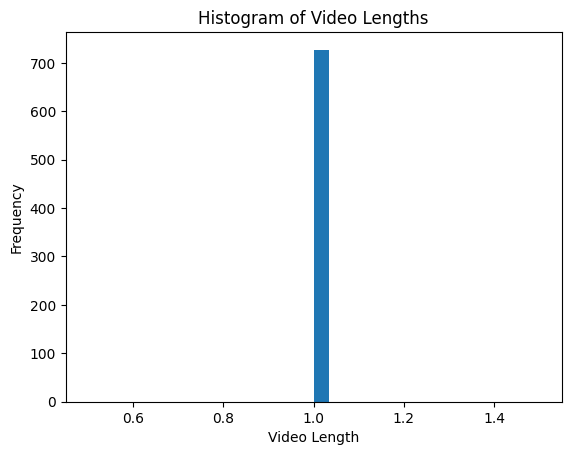

In [13]:
# Compute the lengths of the video sequences
video_lengths = df.groupby('sequence_id').size()
max_seq_length = video_lengths.max()
# max_seq_length = 30
# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [14]:
video_lengths.max()

1

In [15]:
# Create a one-hot encoder
label_encoder = LabelEncoder()

In [16]:
def padding_labels(target):
    integer_encoded = label_encoder.fit_transform(target)
    integer_encoded = integer_encoded.reshape(-1, 1)

    # Encode the word "Hello"
    onehot_encoder = OneHotEncoder(sparse=False)  # sparse=False to get a numpy array as output
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [17]:
target_train = df_train['target'][df_train.groupby('sequence_id').cumcount() == 0].tolist()

In [18]:
X_train = df_train
y_train = padding_labels(target_train)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
del X_train["sequence_id"] 
del X_train["target"] 

print(len(X_train), len(y_train))

703 703


In [20]:
target_test = df_test['target'][df_test.groupby('sequence_id').cumcount() == 0].tolist()

In [21]:
X_test = df_test
y_test = padding_labels(target_test)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
del X_test["sequence_id"] 
del X_test["target"] 

print(len(X_test), len(y_test))

24 24


In [23]:
len(y_train) + len(y_test) == len(df["sequence_id"].unique())

True

In [24]:
models = Models(max_seq_length=1)

In [25]:
X_train_flat = models.get_flat_X(X_train)
X_test_flat = models.get_flat_X(X_test)

# Modelo
La entrada son las coordenadas de la mano que están relacionados en totalidad con la letra (target).
Es un tipo de GLM donde se asume que la distribusión es Gauseana normal. 
No necesita de epocas porque aprende cual es la mejor ecuacion para minimizar el error de predicción.

In [26]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(target_train),
                                        y = target_train                                                    
                                    )
class_weights = dict(zip(np.unique(target_train), class_weights))

In [27]:
# Create an AdaBoost classifier with a base model (e.g., DecisionTreeClassifier)
base_model = DecisionTreeClassifier(max_depth=len(train_letters) - 1, min_samples_split=4, min_samples_leaf=4, class_weight=class_weights)
decision_tree = AdaBoostClassifier(base_model, n_estimators=50, random_state=42)

# Fit the ensemble model
decision_tree.fit(X_train_flat, target_train)

# Make predictions
y_pred_tree = decision_tree.predict(X_test_flat)

# Calculate the accuracy score on a test dataset
accuracy_tree = decision_tree.score(X_test_flat, target_test)

# Print the accuracy
print(f'Accuracy: {accuracy_tree:.2f}')

Accuracy: 0.96


# Guardando el modelo

In [28]:
models.save_model("label_encoder_letters", label_encoder)
models.save_model("tree_letters", decision_tree)

In [29]:
correct = 0
for i in range(len(y_pred_tree)):
    if (target_test[i] == y_pred_tree[i]):
        correct += 1
        # print("Correctamente predicha: ", y_pred_tree[i])
    else:
        print(">>> LOG INCORRECTA: ")
        print("            TREE: ", y_pred_tree[i])
        print("            Correcto: ", target_test[i])

>>> LOG INCORRECTA: 
            TREE:  c
            Correcto:  e


In [30]:
print("Correct >> ", correct)
print("Expected >> ", len(test_data.target.unique()))
print("Ratio >> ", str(correct/len(test_data.target.unique())))

Correct >>  23
Expected >>  24
Ratio >>  0.9583333333333334


# Reutilizando el modelo

In [31]:
load_test_data = pd.read_csv("data/data_test_hola.csv", usecols=get_needed_cols())
load_test_data.head()

,x_Left_hand_0,y_Left_hand_0,x_Left_hand_1,y_Left_hand_1,x_Left_hand_2,y_Left_hand_2,x_Left_hand_3,y_Left_hand_3,x_Left_hand_4,y_Left_hand_4,...,x_Right_hand_16,y_Right_hand_16,x_Right_hand_17,y_Right_hand_17,x_Right_hand_18,y_Right_hand_18,x_Right_hand_19,y_Right_hand_19,x_Right_hand_20,y_Right_hand_20
0,0.094930,0.000000,0.000000,0.238602,0.143721,0.388508,0.366252,0.461758,0.571774,0.478571,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,0.000000,0.624420,0.078278,0.369878,0.200254,0.134536,0.270331,0.000000,0.363182,...,0,0,0,0,0,0,0,0,0,0
2,0.150991,0.000000,0.389191,0.049826,0.626688,0.198339,0.822159,0.275270,1.000000,0.269186,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.090648,0.099391,0.363475,0.337569,0.604508,0.534064,0.815646,0.570140,1.000000,...,0,0,0,0,0,0,0,0,0,0


In [32]:
pretainedModels = PretrainedModelLetters()
results = pretainedModels.get_predictions(load_test_data)

/Users/andreaamaya/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


In [33]:
results

array(['h', 'o', 'l', 'a'], dtype='<U1')

In [34]:
"".join(results)

'hola'